In [ ]:
"""
Goal is to fit a good next-note predictor on a lambda function with reasonable prediction speeds
"""

'\nGoal is to fit a good next-note predictor on a lambda function with reasonable prediction speeds\n'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jembishop1/classical-music-piano-rolls")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/classical-music-piano-rolls


In [ ]:
#GRUVBOX DARK
# basic matplotlib theme of Gruvbox Dark (Medium)
# NOTE: this does not support 3d plots
from matplotlib import rcParams
from cycler import cycler
rcParams['axes.prop_cycle']=cycler(color=['#928374','#8ec07c','#fe8019','#b8bb26','#fabd2f','#83a598','#a89984','#ebdbb2','#fb4934','#d5c4a1','#98971a','#d3869b'])
rcParams['axes.edgecolor']='#ebdbb2'
rcParams['axes.labelcolor']='#ebdbb2'
rcParams['xtick.color']='#ebdbb2'
rcParams['ytick.color']='#ebdbb2'
rcParams['text.color']='#ebdbb2'
rcParams['figure.edgecolor']='#ebdbb2'
rcParams['grid.color']='#ebdbb2'
rcParams['grid.linestyle']=':'
rcParams['axes.facecolor']='#2e2e2e'
rcParams['figure.facecolor']='#2e2e2e'


In [ ]:
import os

os.listdir(path)

['music', 'music.pk']

In [ ]:
import pickle

with open(f"{path}/music.pk", "rb") as f:
    obj1 = pickle.load(f) #data dict

/tmp/ipython-input-204379881.py:4: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  obj1 = pickle.load(f) #data dict


In [ ]:
'''with open(f"{path}/music/music.pk", "rb") as f:
    obj2 = pickle.load(f) #same thign

len(obj1), len(obj2), obj1[0], obj2[0]'''

'with open(f"{path}/music/music.pk", "rb") as f:\n    obj2 = pickle.load(f) #same thign\n\nlen(obj1), len(obj2), obj1[0], obj2[0]'

In [ ]:
try:
  import pypianoroll
except ModuleNotFoundError:
  !pip install pypianoroll
  import pypianoroll

from IPython.display import clear_output

clear_output()
print("Imported pnoroll")

Imported pnoroll


In [ ]:
"""
Looking at the pianoroll representation of the data
"""

'\nLooking at the pianoroll representation of the data\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)

plt.style.use("bmh")

def sparse_to_pianoroll(sparse_matrix):
    arr = sparse_matrix.toarray()
    track = pypianoroll.Track(
        name='Piano',
        program=0,
        is_drum=False
    )
    track.piano_roll = arr
    return track

datasize = 100
obj1 = np.random.choice(obj1, datasize)

start = time.time()
all_pieces = []
batch_size = 16
for i in range(0, len(obj1), batch_size):
    batch = [sparse_to_pianoroll(obj1[j]['piece']) for j in range(i, min(i+batch_size, len(obj1)))]
    all_pieces += batch
    time.sleep(0.5)
end = time.time()
print(f"Converted in {end-start}s")

Converted in 4.332216262817383s


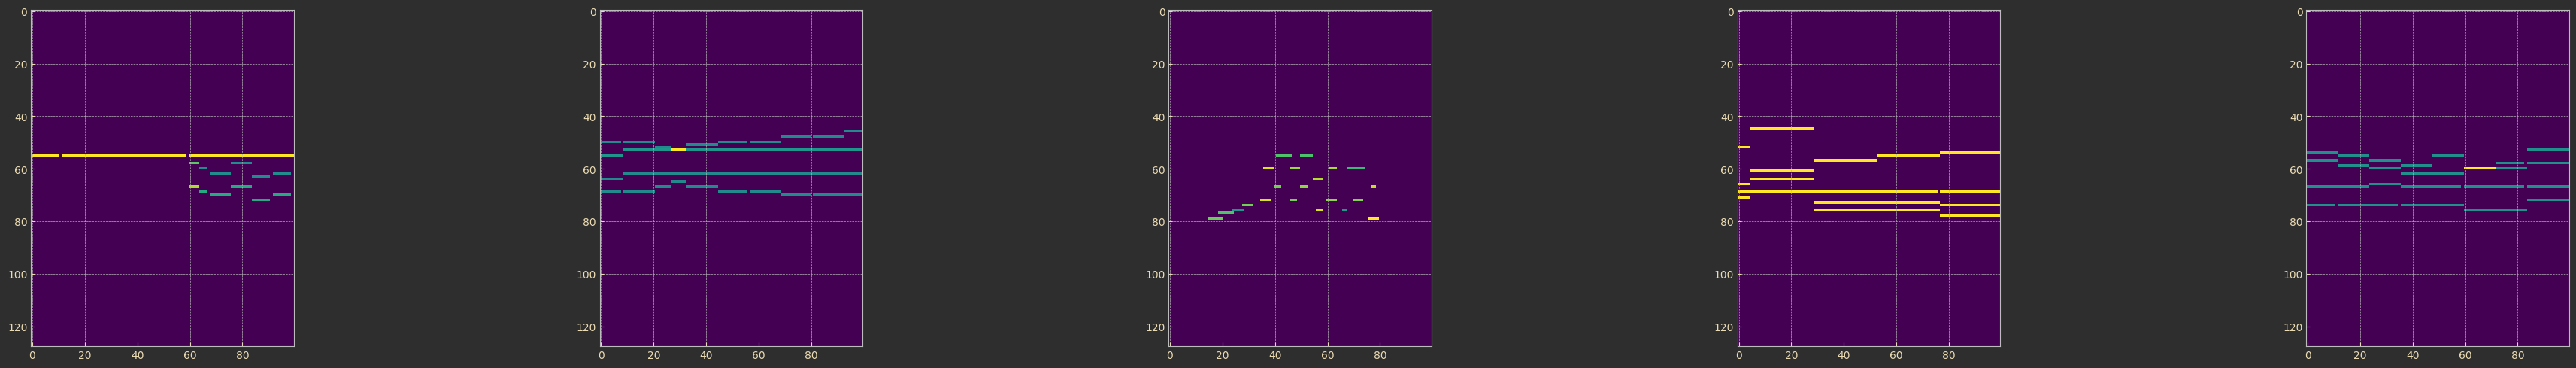

In [ ]:
plt.figure(figsize=(40, 5))
samples = np.random.choice(len(all_pieces), 5)

slice_len = 100

for idx, i in enumerate(samples):
    pr = all_pieces[i].piano_roll

    total_timesteps = pr.shape[0]
    if total_timesteps <= slice_len:
        start_idx = 0
    else:
        start_idx = np.random.randint(0, total_timesteps - slice_len)

    snippet = pr[start_idx:start_idx + slice_len]

    plt.subplot(1, 5, idx + 1)
    plt.imshow(snippet.T)


plt.tight_layout()
plt.show()


100
1319592 117485


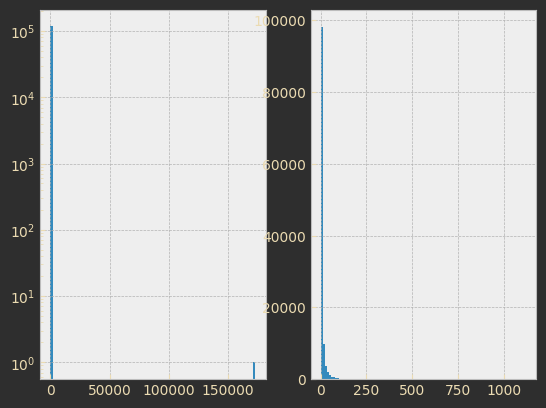

In [ ]:
arrays = [piece.piano_roll for piece in all_pieces]
print(len(arrays))

all_bars = list(np.concatenate(arrays))
unique_bars, counts = np.unique(all_bars, axis = 0, return_counts = True)
print(len(all_bars), len(unique_bars))

plt.subplot(1, 2, 1)
plt.yscale('log')
plt.hist(counts, bins = 100) #Makes little sense to try and do one category per unique bar bc severe overclassification

plt.subplot(1, 2, 2)
plt.hist(counts[1:], bins = 100)
plt.show() #Still no too inflated

In [ ]:
"""
Check for accents
Check for repeated sequences
If we predict by single note, we might get too little rests
But if we predict by single bars, we might get too many rests
"""

'\nCheck for accents\nCheck for repeated sequences\nIf we predict by single note, we might get too little rests\nBut if we predict by single bars, we might get too many rests\n'

In [ ]:
"""
using these notations for an eventual more complex dataset
Tenuto	– (dash)	Slight emphasis, sustain	~65–80
Normal	(none)	Default attack	~50–70
Accent	>	Stronger emphasis	~80–100
Marcato	^ (triangle)	Very strong, short emphasis	~100–120
Fortissimo hit	(none in score)	Max energy, typically percussive	~120–127

we're gonna try
- classification with 0s and 1s
- classification as regression
- classification with accents
"""

"\nusing these notations for an eventual more complex dataset\nTenuto\t– (dash)\tSlight emphasis, sustain\t~65–80\nNormal\t(none)\tDefault attack\t~50–70\nAccent\t>\tStronger emphasis\t~80–100\nMarcato\t^ (triangle)\tVery strong, short emphasis\t~100–120\nFortissimo hit\t(none in score)\tMax energy, typically percussive\t~120–127\n\nwe're gonna try\n- classification with 0s and 1s\n- classification as regression\n- classification with accents\n"

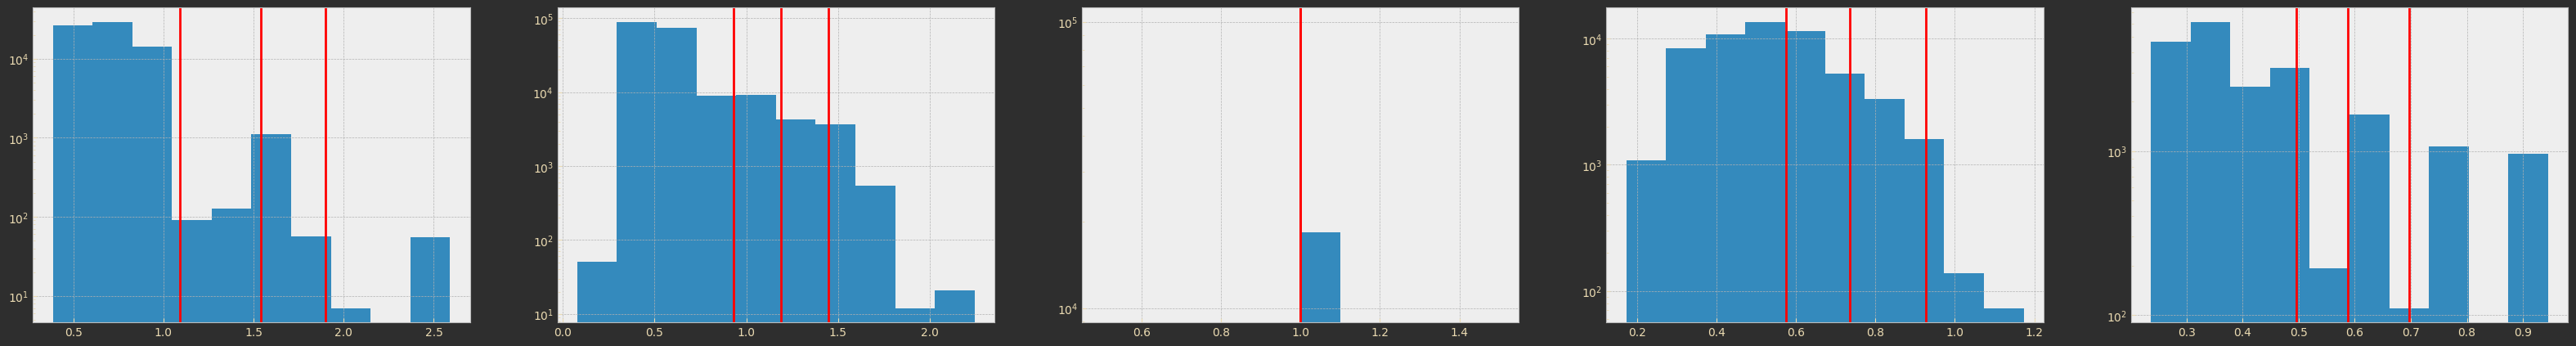

In [ ]:
n_sampels = 5
samples = np.random.choice(len(all_pieces), n_sampels)

plt.figure(figsize=(40, 5))
for idx in range(n_sampels):
    note_data = all_pieces[samples[idx]].piano_roll.flatten()
    note_data = note_data[note_data > 0]

    u = np.unique(note_data)
    cutoffs = [
        np.quantile(u, 0.5), #Tenuto
        np.quantile(u, 0.7), #Accent
        np.quantile(u, 0.9), #Marcato
    ]

    plt.subplot(1, n_sampels, idx + 1)
    plt.hist(note_data)
    plt.yscale('log')

    for c in cutoffs:
        plt.axvline(x = c, color = 'red')



plt.show() #These look p good

In [ ]:
n_tokens_pred = 48
n_tokens_gen = 10 #We're going to eval on the next 10 tokens
n_tokens = n_tokens_pred + n_tokens_gen
#48 to start with, and it's good for generating on composed music
#We wanna overdo predicting at beginning to get good at new music from scratch
#And make sure we put the end to that's also prioritized

tokens = []
accented_tokens = []
binarized_tokens = []

n_samples_per = 40

for piece in all_pieces:
    note_data = piece.piano_roll

    u = np.unique(note_data.flatten())
    cutoffs = [
        np.quantile(u, 0.5), #Tenuto
        np.quantile(u, 0.7), #Accent
        np.quantile(u, 0.9), #Marcato
    ]

    n_samples_at_beginning = n_samples_per // 2

    data_to_use = []
    data_to_use.append(note_data[-n_tokens:])
    for n_to_add in range(1, n_samples_at_beginning + 1):
      rest_data = np.zeros((n_to_add, 128))
      start_data = note_data[:n_tokens - n_to_add]
      data_to_use.append(list(rest_data) + list(start_data))

    for _ in range(n_samples_per - n_samples_at_beginning - 1):
      start = np.random.randint(0, len(note_data) - n_tokens)
      data_to_use.append(note_data[start : start + n_tokens])

    tokens += data_to_use



tokens = np.array(tokens)

tokens.shape

(4000, 58, 128)

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

class Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        x = sample[:n_tokens_pred]  # First 48 tokens
        y = sample[n_tokens_pred : n_tokens_pred + n_tokens_gen]   # Eval tokens
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y[0], dtype = torch.float32), torch.tensor(y, dtype=torch.float32)


tokens_dataset = Dataset(tokens)



train_size = int(0.8 * len(tokens_dataset))
val_size = len(tokens_dataset) - train_size

tokens_train_dataset, tokens_val_dataset = random_split(tokens_dataset, [train_size, val_size])

batch_size = 32
tokens_train = DataLoader(tokens_train_dataset, batch_size=batch_size, shuffle=True)
tokens_test = DataLoader(tokens_val_dataset, batch_size=batch_size, shuffle=True)

print(len(tokens_train))

100


In [ ]:
"""Storage:
- Ephemeral storage (/tmp): 512 MB (default, not expandable in free tier).
- Deployment package size:
    * Compressed (.zip): up to 50 MB (direct upload) or 250 MB (via Amazon S3).
    * Uncompressed: up to 250 MB, including layers.

Memory (RAM):
- Configurable from 128 MB to 10,240 MB (10 GB), in 1 MB increments.
- Free limit = 150 MB configured
- CPU power scales proportionally with memory size.
"""

'Storage:\n- Ephemeral storage (/tmp): 512 MB (default, not expandable in free tier).\n- Deployment package size:\n    * Compressed (.zip): up to 50 MB (direct upload) or 250 MB (via Amazon S3).\n    * Uncompressed: up to 250 MB, including layers.\n\nMemory (RAM):\n- Configurable from 128 MB to 10,240 MB (10 GB), in 1 MB increments.\n- Free limit = 150 MB configured\n- CPU power scales proportionally with memory size.\n'

In [ ]:
from torchsummary import summary

 #RAM estimates

In [ ]:
def test_model_size(model):
  tmp_path = "tmp.pth"
  torch.save(model.state_dict(), tmp_path)
  size = os.path.getsize(tmp_path)
  os.remove(tmp_path)
  return size

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'



class BasicTrans(nn.Module):

    def __init__(self, input_shape, n_classes, num_heads, num_blocks, dim_feedforward, dropout, sigmoid, temp, embed_dim = None):
        super(BasicTrans, self).__init__()

        self.input_shape = input_shape
        self.n_classes = n_classes


        self.projection = nn.Linear(self.input_shape[1], embed_dim)

        self.attention_stack = nn.ModuleList([
            nn.ModuleList([
                nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, batch_first=True),
                nn.LayerNorm((input_shape[0], embed_dim)), #i[0], e
                nn.Dropout(dropout)
            ])
            for _ in range(num_blocks) #num blocks
        ])

        self.linear1 = nn.Linear(input_shape[0], dim_feedforward) # e * i[0]
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout) #lambda x : F.dropout(x, dropout)
        self.linear2 = nn.Linear(dim_feedforward, n_classes)
        self.norm2 = nn.LayerNorm((input_shape[1], dim_feedforward)) #in[1], dim_f
        self.norm3 = nn.LayerNorm((input_shape[1], n_classes))  #in[1], n_c
        self.dropout3 =  nn.Dropout(dropout) #lambda x : F.dropout(x, dropout)

        self.sigmoid = sigmoid
        self.temp = temp


    def forward(self, x):
        x = x.to(device)

        bsize, slen, flen = x.shape

        x = self.projection(x)


        for block in self.attention_stack:
            att_out = block[0](x, x, x)[0]
            x = x + self.dropout2(att_out)
            x = block[1](x)
            x = block[2](x)


        batch_size, seq_len, embedding_dim = x.shape
        x = x.view(batch_size, self.input_shape[1], seq_len * embedding_dim // self.input_shape[1])
        x = self.linear1(x)
        x = self.relu(x)

        x = self.dropout2(x)
        x = self.norm2(x)
        x = self.linear2(x)

        x = self.dropout3(x)
        x = self.norm3(x)
        x = self.relu(x)


        x = x.permute(0, 2, 1)


        return x.view(bsize, 1, flen)


In [ ]:
tok_model = BasicTrans(
    input_shape=(48, 128),
    n_classes=1,
    num_heads=4,
    num_blocks=1,
    dim_feedforward=256,
    dropout=0.1,
    embed_dim = 128,
    sigmoid = True,
    temp = 0.8
).to(device)

print(test_model_size(tok_model) / (1024 ** 2))
summary(tok_model, (48, 128))

0.666590690612793
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 48, 128]          16,512
MultiheadAttention-2  [[-1, 48, 128], [-1, 48, 48]]               0
           Dropout-3              [-1, 48, 128]               0
         LayerNorm-4              [-1, 48, 128]          12,288
           Dropout-5              [-1, 48, 128]               0
            Linear-6             [-1, 128, 256]          12,544
              ReLU-7             [-1, 128, 256]               0
           Dropout-8             [-1, 128, 256]               0
         LayerNorm-9             [-1, 128, 256]          65,536
           Linear-10               [-1, 128, 1]             257
          Dropout-11               [-1, 128, 1]               0
        LayerNorm-12               [-1, 128, 1]             256
             ReLU-13               [-1, 128, 1]               0
Total params: 107

In [ ]:
!pip install pytorch-lightning
clear_output()

In [ ]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def regression_loss(y_pred, y_true, gen_pred = None, gen_true = None,
                    mse_w = 1, lam=0.35, cos_w=0.5,
                    mse_wg = 0.035, cos_wg = 0.05):

    #Token-token comparison
    y_pred = y_pred.float()
    y_true = y_true.float()

    mse = F.mse_loss(y_pred, y_true)

    y_pred_flat = y_pred.view(-1, y_pred.size(-1))
    y_true_flat = y_true.view(-1, y_true.size(-1))
    cos_loss = 1 - F.cosine_similarity(y_pred_flat, y_true_flat, dim=-1).mean()

    var_penalty = -lam * y_pred.var(dim=1).mean()

    L = mse * mse_w + cos_w * cos_loss + var_penalty

    #Sequence comparison
    if gen_pred is not None and gen_true is not None:
      gen_pred = gen_pred.float()
      gen_true = gen_true.float()

      closs = F.cosine_similarity(gen_pred.unsqueeze(1), gen_pred.unsqueeze(0), dim=-1)
      mask = ~torch.eye(gen_pred.size(0), dtype=bool, device=gen_pred.device)
      closs = closs[mask].mean()

      mse = F.mse_loss(gen_pred, gen_true)

      L += mse_wg * mse + cos_wg * closs

    return L

In [ ]:

class LitTransformer(pl.LightningModule):
    def __init__(self, model, lr=1e-3, lr_decay_factor=0.5, lr_patience=2,
                 lr_cutoff=1e-4,
                 lossfn = lambda a,b,c,d : regression_loss(a,b,c,d), metric_function=None, verbose=1):
        super().__init__()
        self.model = model
        self.lr = lr
        self.lr_decay_factor = lr_decay_factor
        self.lr_patience = lr_patience
        self.lr_cutoff = lr_cutoff
        self.metric_function = metric_function
        self.verbose = verbose

        # Storage for plotting
        self.train_losses, self.val_losses = [], []
        self.train_metrics, self.val_metrics = [], []
        self.epoch_checkpoints_train, self.epoch_checkpoints_val = [], []

        # Per-epoch storage
        self.val_losses_epoch = []
        self.val_metrics_epoch = []

        self.last_val_loss = float("inf")

        self.loss = lossfn

    def forward(self, x):
        return self.model(x)


    def training_step(self, batch, batch_idx):
        inputs, labels, full_labels = batch
        outputs = self(inputs)

        gen = generate_samples(self.model, inputs.cpu().detach().numpy(), n = n_tokens_gen, use_cutoff = False)
        gen = gen[:, n_tokens_pred : n_tokens_pred + n_tokens_gen]

        loss = self.loss(outputs.squeeze(), labels, gen, full_labels)

        self.train_losses.append(loss.item())
        if self.metric_function:
            metric = self.metric_function(outputs.cpu().detach(), labels.cpu().detach())
            self.train_metrics.append(metric)

        # Log for Lightning
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return {"loss": loss}



    def validation_step(self, batch, batch_idx):
        inputs, labels, full_labels = batch
        outputs = self(inputs)

        gen = generate_samples(self.model, inputs.cpu().detach().numpy(), n = n_tokens_gen, use_cutoff = False)
        gen = gen[:, n_tokens_pred : n_tokens_pred + n_tokens_gen]

        loss = self.loss(outputs.squeeze(), labels, gen, full_labels)

        self.val_losses.append(loss.item())
        self.val_losses_epoch.append(loss.item())

        metric = None
        if self.metric_function:
            metric = self.metric_function(outputs.cpu().detach(), labels.cpu().detach())
            self.val_metrics.append(metric)
            self.val_metrics_epoch.append(metric)

        return {"val_loss": loss, "val_metric": metric}


    def on_validation_epoch_end(self):
        val_loss = np.mean(self.val_losses_epoch) if self.val_losses_epoch else 0.0
        val_metric = np.mean(self.val_metrics_epoch) if self.val_metrics_epoch else 0.0

        # Log so LR scheduler sees it
        self.log("val_loss", val_loss, prog_bar=True, on_epoch=True)
        if self.metric_function:
            self.log("val_metric", val_metric, prog_bar=True, on_epoch=True)

        # Checkpoints for plotting
        self.epoch_checkpoints_train.append(len(self.train_losses))
        self.epoch_checkpoints_val.append(len(self.val_losses))

        # Verbose feedback
        if self.verbose == 1:
            diff = (self.last_val_loss - val_loss) if self.last_val_loss != float("inf") else 0.0
            print(f"Epoch {self.current_epoch+1}/{self.trainer.max_epochs}, "
                  f"Val Loss: {val_loss:.4f}, Diff: {diff:.4f}, Val Metric: {val_metric:.4f}")

        self.last_val_loss = val_loss

        # Clear per-epoch storage
        self.val_losses_epoch.clear()
        self.val_metrics_epoch.clear()


    def on_train_end(self):
        if self.verbose != 1:
            return

        def normalize(series):
            if not series:
                return []
            series = np.array(series).reshape(-1, 1)
            return MinMaxScaler().fit_transform(series).flatten()

        train_loss_scaled = normalize(self.train_losses)
        val_loss_scaled = normalize(self.val_losses)
        train_metric_scaled = normalize(self.train_metrics)
        val_metric_scaled = normalize(self.val_metrics)

        fig = plt.figure(figsize=(12, 4))

        # Train
        plt.subplot(1, 2, 1)
        if len(train_loss_scaled): plt.plot(train_loss_scaled, label="Train Loss (scaled)")
        if len(train_metric_scaled): plt.plot(train_metric_scaled, label="Train Metric (scaled)")
        for check in self.epoch_checkpoints_train:
            plt.axvline(x=check, color="red", linestyle="--", linewidth=1)
        plt.title("Train")
        plt.legend()

        # Validation
        plt.subplot(1, 2, 2)
        if len(val_loss_scaled): plt.plot(val_loss_scaled, label="Val Loss (scaled)")
        if len(val_metric_scaled): plt.plot(val_metric_scaled, label="Val Metric (scaled)")
        for check in self.epoch_checkpoints_val:
            plt.axvline(x=check, color="red", linestyle="--", linewidth=1)
        plt.title("Validation")
        plt.legend()

        plt.tight_layout()
        plt.show()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = {
            "scheduler": ReduceLROnPlateau(
                optimizer,
                mode="min",
                factor=self.lr_decay_factor,
                patience=self.lr_patience,
                threshold=self.lr_cutoff,
                threshold_mode="rel"
            ),
            "monitor": "val_loss"
        }
        return [optimizer], [scheduler]


In [ ]:
def generate_samples(model, data, n=48, use_cutoff=True, sig = False, temp = 1):
    model = model.to('cuda')
    data = torch.from_numpy(data).to('cuda').float()

    generated = []
    original_data = data[:48+n]  # keep reference
    data = data[:48]

    slen, flen = data.shape[-2], data.shape[-1]
    bsize = data.shape[0] if len(data.shape) == 3 else 1

    u = torch.unique(data)
    cutoff = 0.0
    try:
      cutoff = sorted(u.cpu().numpy())[1]
    except Exception as e:
      cutoff = 0.0

    for _ in range(n):
        p = model(data.view(bsize, slen, flen)) #Assuming correct 3-D output shape

        if use_cutoff:
            cutoff_val = torch.tensor(cutoff, device=p.device, dtype=p.dtype)
            x = p * torch.sigmoid((p - cutoff_val) * 10.0)  # differentiable
        else:
            x = p

        #temp + sig
        x = temp * x
        if sig:
          x = F.sigmoid(x)

        generated.append(x)

        data = torch.cat([data.view(bsize, slen, flen), x.view(bsize, 1, flen)], dim=1)[:, 1:]

    x = original_data[:48]
    y = torch.cat(generated, dim = 1)
    pianoroll_generated = torch.cat([
        x.view(bsize, 48, flen), y
      ], dim=1
    )

    return pianoroll_generated


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 48, 128]          16,512
MultiheadAttention-2  [[-1, 48, 128], [-1, 48, 48]]               0
           Dropout-3              [-1, 48, 128]               0
         LayerNorm-4              [-1, 48, 128]          12,288
           Dropout-5              [-1, 48, 128]               0
            Linear-6             [-1, 128, 256]          12,544
              ReLU-7             [-1, 128, 256]               0
           Dropout-8             [-1, 128, 256]               0
         LayerNorm-9             [-1, 128, 256]          65,536
           Linear-10               [-1, 128, 1]             257
          Dropout-11               [-1, 128, 1]               0
        LayerNorm-12               [-1, 128, 1]             256
             ReLU-13               [-1, 128, 1]               0
Total params: 107,393
Trainable par

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | BasicTrans | 173 K  | train
---------------------------------------------
173 K     Trainable params
0         Non-trainable params
173 K     Total params
0.694     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/tmp/ipython-input-3366584915.py:65: UserWarning: Using a target size (torch.Size([32, 128])) that is different to the input size (torch.Size([32, 1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  metric = self.metric_function(outputs.cpu().detach(), labels.cpu().detach())


Epoch 1/30, Val Loss: 0.6908, Diff: 0.0000, Val Metric: 0.4029


Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipython-input-3366584915.py:42: UserWarning: Using a target size (torch.Size([32, 128])) that is different to the input size (torch.Size([32, 1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  metric = self.metric_function(outputs.cpu().detach(), labels.cpu().detach())


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1/30, Val Loss: 0.3486, Diff: 0.3421, Val Metric: 0.2358


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2/30, Val Loss: 0.3240, Diff: 0.0246, Val Metric: 0.1792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3/30, Val Loss: 0.2959, Diff: 0.0281, Val Metric: 0.1404


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4/30, Val Loss: 0.2803, Diff: 0.0155, Val Metric: 0.1156


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5/30, Val Loss: 0.2736, Diff: 0.0067, Val Metric: 0.1011


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6/30, Val Loss: 0.2658, Diff: 0.0078, Val Metric: 0.0917


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7/30, Val Loss: 0.2585, Diff: 0.0074, Val Metric: 0.0848


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8/30, Val Loss: 0.2470, Diff: 0.0115, Val Metric: 0.0751


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9/30, Val Loss: 0.2336, Diff: 0.0134, Val Metric: 0.0686


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10/30, Val Loss: 0.2337, Diff: -0.0002, Val Metric: 0.0693


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11/30, Val Loss: 0.2166, Diff: 0.0171, Val Metric: 0.0585


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12/30, Val Loss: 0.2136, Diff: 0.0031, Val Metric: 0.0533


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13/30, Val Loss: 0.2071, Diff: 0.0065, Val Metric: 0.0567


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14/30, Val Loss: 0.2012, Diff: 0.0058, Val Metric: 0.0558


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15/30, Val Loss: 0.1950, Diff: 0.0063, Val Metric: 0.0488


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16/30, Val Loss: 0.1940, Diff: 0.0009, Val Metric: 0.0519


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17/30, Val Loss: 0.1864, Diff: 0.0076, Val Metric: 0.0457


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18/30, Val Loss: 0.1846, Diff: 0.0018, Val Metric: 0.0466


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19/30, Val Loss: 0.1816, Diff: 0.0030, Val Metric: 0.0463


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20/30, Val Loss: 0.1812, Diff: 0.0004, Val Metric: 0.0419


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21/30, Val Loss: 0.1852, Diff: -0.0040, Val Metric: 0.0459


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22/30, Val Loss: 0.1758, Diff: 0.0094, Val Metric: 0.0432


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23/30, Val Loss: 0.1753, Diff: 0.0006, Val Metric: 0.0448


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24/30, Val Loss: 0.1734, Diff: 0.0018, Val Metric: 0.0393


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25/30, Val Loss: 0.1708, Diff: 0.0026, Val Metric: 0.0407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26/30, Val Loss: 0.1729, Diff: -0.0021, Val Metric: 0.0568


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27/30, Val Loss: 0.1675, Diff: 0.0054, Val Metric: 0.0427


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28/30, Val Loss: 0.1670, Diff: 0.0005, Val Metric: 0.0429


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29/30, Val Loss: 0.1623, Diff: 0.0047, Val Metric: 0.0414


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30, Val Loss: 0.1601, Diff: 0.0022, Val Metric: 0.0415


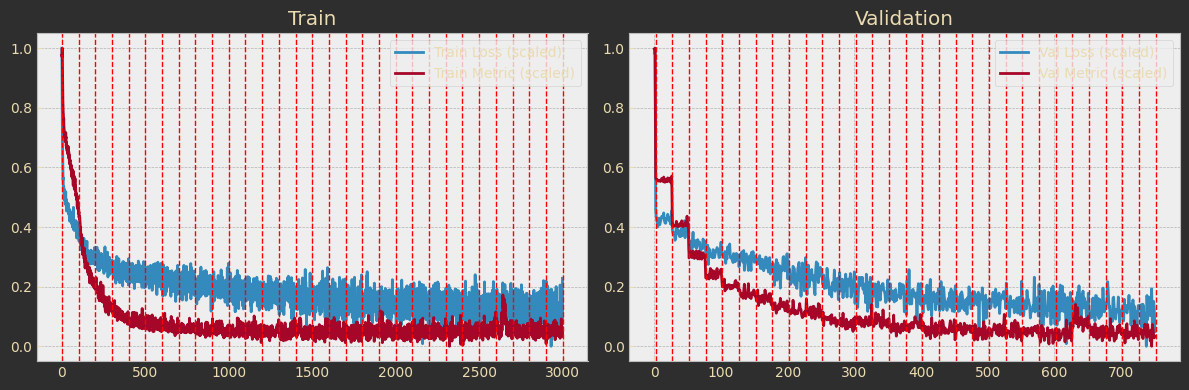

In [ ]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, TensorDataset



tok_model = BasicTrans(
    input_shape=(48, 128),
    n_classes=1,
    num_heads=8,
    num_blocks=1,
    dim_feedforward=256,
    dropout=0.25,
    sigmoid = True,
    temp = 1,
    embed_dim = 128
).to(device)

summary(tok_model, (48, 128))


loss_args = {
    "mse_w": 1,
    "lam": 0.5,
    "cos_w": 0.3,
    "mse_wg": 0.05,
    "cos_wg": 0.03
}


lit_model = LitTransformer(tok_model, lr=1e-3, lr_decay_factor = 0.8, lr_patience = 5, lr_cutoff = 1e-6,
                           lossfn = lambda a,b,c,d : regression_loss(a,b,c,d, **loss_args), metric_function = F.l1_loss)

# Trainer
trainer = Trainer(max_epochs=30)
trainer.fit(lit_model, tokens_train, tokens_test)


In [ ]:
def eval_with_dataset(model, data, sig, temp, n = 48, cutoff = True):
  pianoroll_generated = generate_samples(model, data, n, cutoff, sig = sig, temp = temp).cpu().detach().numpy()

  original_data = data[:48]

  plt.figure(figsize = (10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Original")
  plt.imshow(original_data.T)
  plt.grid(False)
  plt.subplot(1, 2, 2)
  plt.title("Generated")
  plt.imshow(pianoroll_generated.T)
  plt.grid(False)

  plt.tight_layout()
  plt.show()

  return pianoroll_generated

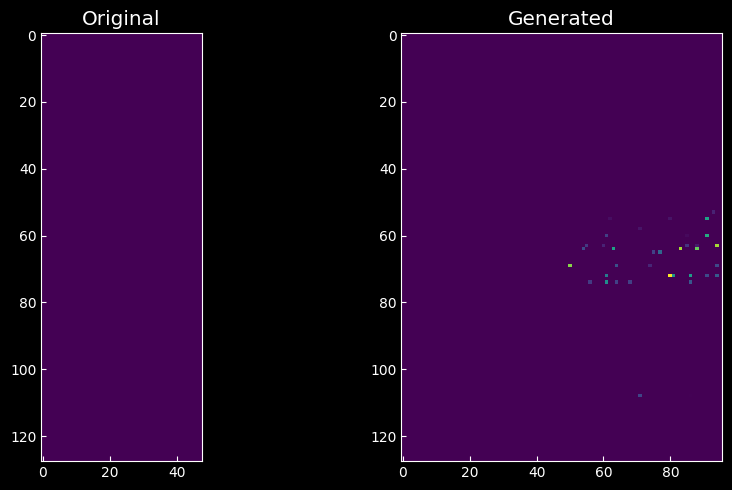

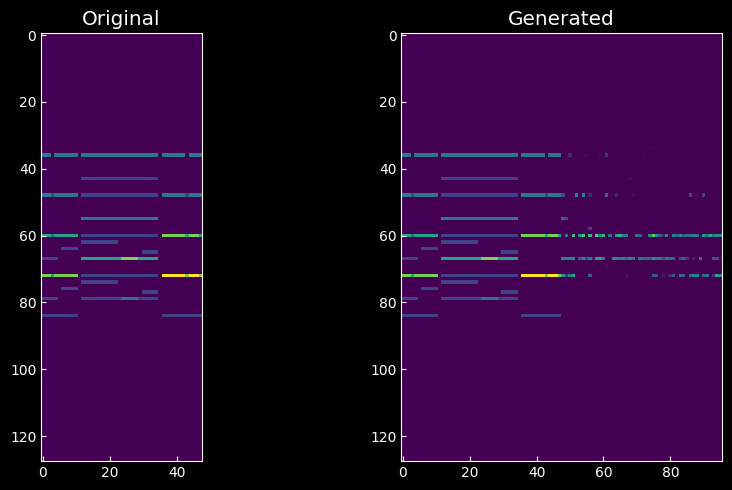

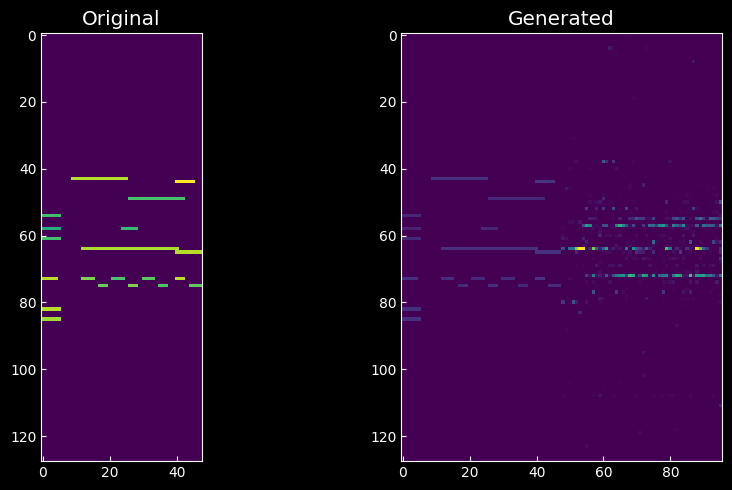

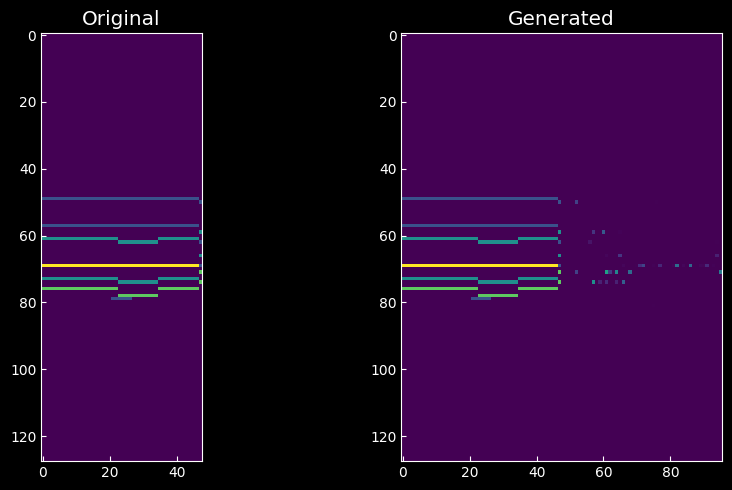

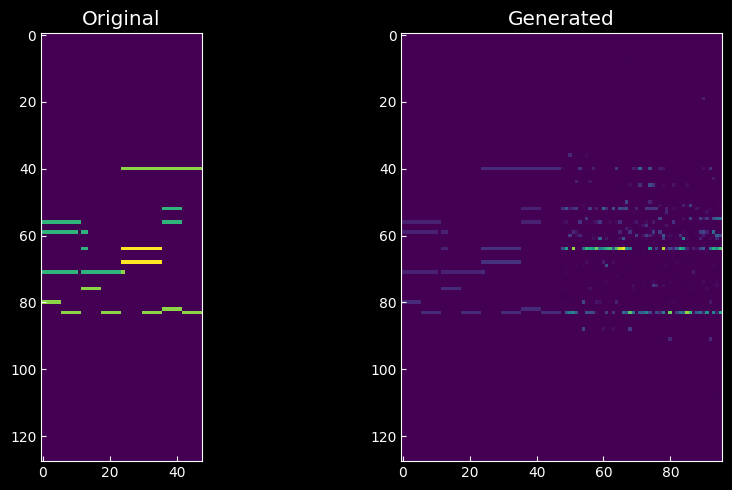

In [ ]:
n = 200
plt.style.use("dark_background")

X = []

for _ in range(5):
  piece = all_pieces[np.random.randint(0, len(all_pieces))].piano_roll
  starting_idx = np.random.randint(0, len(piece) - 48 - n)
  sample = piece[starting_idx : starting_idx + 48 + n]
  if np.random.random() > 0.5:
    sample = np.zeros_like(sample)
  x = eval_with_dataset(tok_model, sample, cutoff = True, sig = False, temp = 1)

In [ ]:
'''

tok_model = BasicTrans(
    input_shape=(48, 128),
    n_classes=1,
    num_heads=8,
    num_blocks=1,
    dim_feedforward=256,
    dropout=0.25,
    sigmoid = True,
    temp = 0.7,
    embed_dim = 128
).to(device)

summary(tok_model, (48, 128))


loss_args = {
    "mse_w": 1,
    "lam": 0.5,
    "cos_w": 0.3,
    "mse_wg": 0.05,
    "cos_wg": 0.03
}


'''

'\n\ntok_model = BasicTrans(\n    input_shape=(48, 128),\n    n_classes=1,\n    num_heads=8,\n    num_blocks=1,\n    dim_feedforward=256,\n    dropout=0.25,\n    sigmoid = True,\n    temp = 0.7,\n    embed_dim = 128\n).to(device)\n\nsummary(tok_model, (48, 128))\n\n\nloss_args = {\n    "mse_w": 1,\n    "lam": 0.5,\n    "cos_w": 0.3,\n    "mse_wg": 0.05,\n    "cos_wg": 0.03\n}\n\n\n'

In [ ]:
tok_model = tok_model.to('cpu')
device = 'cpu'

In [ ]:
class TorchscriptTrans(nn.Module):

    def __init__(self, input_shape, n_classes, num_heads, num_blocks, dim_feedforward, dropout, sigmoid, temp, embed_dim = None):
        super(TorchscriptTrans, self).__init__()

        self.input_shape = input_shape
        self.n_classes = n_classes


        self.projection = nn.Linear(self.input_shape[1], embed_dim)

        self.attention_stack = nn.ModuleList([
            nn.ModuleList([
                nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, batch_first=True),
                nn.LayerNorm((input_shape[0], embed_dim)), #i[0], e
                nn.Dropout(dropout)
            ])
            for _ in range(num_blocks) #num blocks
        ])

        self.linear1 = nn.Linear(input_shape[0], dim_feedforward) # e * i[0]
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout) #lambda x : F.dropout(x, dropout)
        self.linear2 = nn.Linear(dim_feedforward, n_classes)
        self.norm2 = nn.LayerNorm((input_shape[1], dim_feedforward)) #in[1], dim_f
        self.norm3 = nn.LayerNorm((input_shape[1], n_classes))  #in[1], n_c
        self.dropout3 =  nn.Dropout(dropout) #lambda x : F.dropout(x, dropout)

        self.sigmoid = sigmoid
        self.temp = temp


    def forward(self, x):
        bsize, slen, flen = x.shape

        x = self.projection(x)


        for block in self.attention_stack:
            att_out = block[0](x, x, x)[0]
            x = x + self.dropout2(att_out)
            x = block[1](x)
            x = block[2](x)


        batch_size, seq_len, embedding_dim = x.shape
        x = x.view(batch_size, self.input_shape[1], seq_len * embedding_dim // self.input_shape[1])
        x = self.linear1(x)
        x = self.relu(x)

        x = self.dropout2(x)
        x = self.norm2(x)
        x = self.linear2(x)

        x = self.dropout3(x)
        x = self.norm3(x)
        x = self.relu(x)


        x = x.permute(0, 2, 1)


        return x.view(bsize, 1, flen)


In [ ]:
script_model = TorchscriptTrans(
    input_shape=(48, 128),
    n_classes=1,
    num_heads=8,
    num_blocks=1,
    dim_feedforward=256,
    dropout=0.25,
    sigmoid = True,
    temp = 0.7,
    embed_dim = 128
).to(device)

In [ ]:
s = time.time()
x = script_model(torch.randn((1, 48, 128)).to(device))
end = time.time()
print(f"Time took: {(end - start) // 1000}")

Time took: 1756684.0


In [ ]:
state = tok_model.state_dict()
script_model.load_state_dict(state)
script_model.eval()

TorchscriptTrans(
  (projection): Linear(in_features=128, out_features=128, bias=True)
  (attention_stack): ModuleList(
    (0): ModuleList(
      (0): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (1): LayerNorm((48, 128), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (linear1): Linear(in_features=48, out_features=256, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
  (norm2): LayerNorm((128, 256), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((128, 1), eps=1e-05, elementwise_affine=True)
  (dropout3): Dropout(p=0.25, inplace=False)
)

In [ ]:
cell = torch.jit.script(script_model)
cell.code

'def forward(self,\n    x: Tensor) -> Tensor:\n  bsize, slen, flen, = torch.size(x)\n  projection = self.projection\n  x0 = (projection).forward(x, )\n  attention_stack = self.attention_stack\n  _0 = getattr(attention_stack, "0")\n  _00 = getattr(_0, "0")\n  _1 = (_00).forward(x0, x0, x0, None, True, None, True, False, )\n  att_out = (_1)[0]\n  dropout2 = self.dropout2\n  x1 = torch.add(x0, (dropout2).forward(att_out, ))\n  _10 = getattr(_0, "1")\n  x2 = (_10).forward(x1, )\n  _2 = getattr(_0, "2")\n  x3 = (_2).forward(x2, )\n  batch_size, seq_len, embedding_dim, = torch.size(x3)\n  input_shape = self.input_shape\n  _3 = (input_shape)[1]\n  _4 = torch.mul(seq_len, embedding_dim)\n  input_shape0 = self.input_shape\n  _5 = [batch_size, _3, torch.floordiv(_4, (input_shape0)[1])]\n  x4 = torch.view(x3, _5)\n  linear1 = self.linear1\n  x5 = (linear1).forward(x4, )\n  relu = self.relu\n  x6 = (relu).forward(x5, )\n  dropout20 = self.dropout2\n  x7 = (dropout20).forward(x6, )\n  norm2 = self.

In [ ]:
cell.graph

graph(%self : __torch__.TorchscriptTrans,
      %x.1 : Tensor):
  %27 : bool = prim::Constant[value=0]()
  %24 : bool = prim::Constant[value=1]()
  %23 : NoneType = prim::Constant()
  %13 : int = prim::Constant[value=0]() # /tmp/ipython-input-777602011.py:39:8
  %36 : int = prim::Constant[value=1]() # /tmp/ipython-input-777602011.py:42:22
  %45 : int = prim::Constant[value=2]() # /tmp/ipython-input-777602011.py:43:22
  %3 : int[] = aten::size(%x.1) # <string>:13:9
  %bsize.1 : int, %slen : int, %flen.1 : int = prim::ListUnpack(%3)
  %projection : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="projection"](%self)
  %x.7 : Tensor = prim::CallMethod[name="forward"](%projection, %x.1) # /tmp/ipython-input-777602011.py:36:12
  %attention_stack : __torch__.torch.nn.modules.container.___torch_mangle_0.ModuleList = prim::GetAttr[name="attention_stack"](%self)
  %_0.1 : __torch__.torch.nn.modules.container.ModuleList = prim::GetAttr[name="0"](%attention_stack)
  %_0.3 : __torch_

In [ ]:
cell.save("trans_sript.pt")